<a href="https://colab.research.google.com/github/kuramapw/rfslf/blob/master/Copy_of_QPSK_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#инициализация необходимых библиотек
import random     
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
fd=10**9  #частота дискретизации
fn=10**8  #частота несущей
els=5
length=int(fd*els/fn)

In [0]:
#здесь мы вбиваем текст, преобразуем его в двоичный код
def text_to_bits(text, encoding='utf-8', errors='surrogatepass'):
    bits = bin(int.from_bytes(text.encode(encoding, errors), 'big'))[2:]
    return bits.zfill(8 * ((len(bits) + 7) // 8))

In [0]:
#здесь мы из двоичного кода получаем текст
def text_from_bits(bits, encoding='utf-8', errors='surrogatepass'):
    n = int(bits, 2)
    return n.to_bytes((n.bit_length() + 7) // 8, 'big').decode(encoding, errors) or '\0'

In [0]:
#функция модуляции QPSK
def QPSK(d1,d2,t,fn):                                       
    return  (2.**(-0.5))*(d1*np.cos(2.*np.pi*fn*t) + d2*np.sin(2.*np.pi*fn*t))

In [0]:
#здесь мы преобразуем текст в колебание с манипуляцией QPSK
def manipulator(information, fd, fn, els, graph=0):
    sig=information
    #print(sig)
    sigtemp=np.array([],int)
    n=int(np.shape(sig)[0])
    #print(n)
    length=int(els*fd/fn)
    for i in sig:
        if(i==0):
            sigtemp=np.append(sigtemp,-1)
        if(i==1):
            sigtemp=np.append(sigtemp,1)
    #print(sigtemp)
    signaltemp=[]                                                 #делаем вспомогательный массив из пар битов [-1,1]
    i=0
    while i<n:
        signaltemp.append([sigtemp[i],sigtemp[i+1]])
        i=i+2
    #print(signaltemp)
    s=np.array([],float)
    global time
    time=np.arange(0,int(length*n/2)/fd,1/fd)
    i=0
    while i<(n/2):
        t=time[i*length:length*(i+1)]
        temp1=QPSK( signaltemp[i][0] , signaltemp[i][1] , t , fn )
        s=np.append(s,temp1)
        i=i+1 
    if(graph==1):
        plt.figure(num=None, figsize=(19, 4), dpi=80) 
        plt.plot(list(time),list(s))      
        plt.show()
    return s


In [0]:
info=np.array(list(text_to_bits("Рассмотрим прямоугольный волновод, при условии что он является регулярным и его стенки идеально проводящие. Значит вместо шести неизвестных компонент поля имеем только две: Ez и Hz, при этом задача о нахождении полей волновода распадается на две независимые (краевые) задачи.Значит в данном волноводе существует два типа волн: TE и TM. Прямоугольный волновод - металлический волновод прямоугольной формы, способный поддерживать распространяющиеся вдоль него волны.")),int)
s=manipulator(info, fd, fn, els, 0)
print(info)

[1 1 0 ... 1 1 0]


50


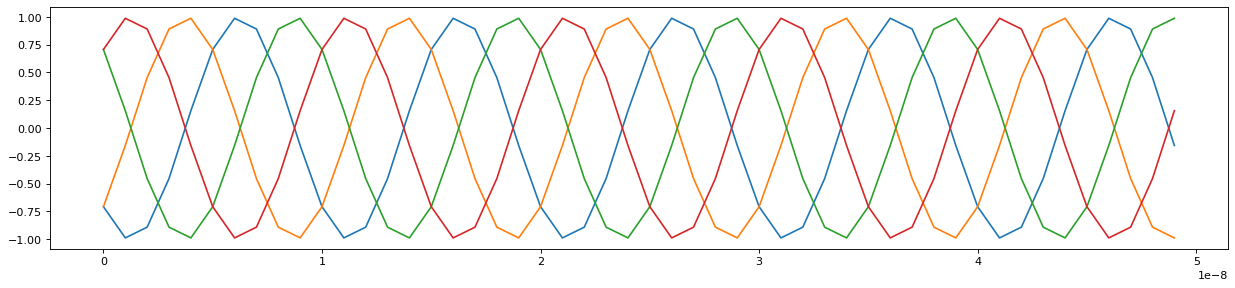

In [0]:
#формируем эталонные массивы
s00=np.array([])    
s01=np.array([])
s10=np.array([])
s11=np.array([])
t=np.array([])
for i in range(length):
    t=np.append(t,i/fd)
print(len(t))
s00=np.append(s00,QPSK(-1,-1,t,fn))
s01=np.append(s01,QPSK(-1,1,t,fn))
s10=np.append(s10,QPSK(1,-1,t,fn))
s11=np.append(s11,QPSK(1,1,t,fn))
plt.figure(num=None, figsize=(19, 4), dpi=80) 
plt.plot(t, s00)
plt.plot(t, s01)
plt.plot(t, s10)
plt.plot(t, s11)     
plt.show()

In [0]:
#корреляционный детектор
def kor_priem(intern_signal):      
    kf0=kf1=kf2=kf3=0
    dt=t[1]-t[0]

    for i in range(len(t)):
        kf0+=intern_signal[i]*s00[i]*dt
        kf1+=intern_signal[i]*s01[i]*dt
        kf2+=intern_signal[i]*s10[i]*dt
        kf3+=intern_signal[i]*s11[i]*dt
    mx=max(kf0,kf1,kf2,kf3)
    if(mx==kf0):
        return [0,0]
    if(mx==kf1):
        return [0,1]
    if(mx==kf2):
        return [1,0]
    if(mx==kf3):
        return [1,1]

In [0]:
#Здесь мы принимаем колебание и достаем оттуда информацию
def priemnik(input_signal,fd,fn,els, graph=0):
    x_intern=input_signal
    s_intern=np.array([],int)
    for i in range(int(len(input_signal)/(length))):
        s_intern=np.append(s_intern, kor_priem(x_intern[i*length:length*(i+1)]))
    if(graph==1):
        plt.figure(num=None, figsize=(19, 4), dpi=80) 
        plt.plot(time, x_intern)
        plt.show()
    return s_intern

In [0]:
#d=2
#noise=[np.random.normal(0,d) for i in s]
#wave=s+noise
#plt.figure(num=None, figsize=(19,4), dpi=80)
#plt.plot(time, wave)
#plt.plot(time, manipulator(priemnik(wave,fd,fn,els),fd,fn,els))
#plt.plot(time, noise)
#plt.show()
#зависимость ошибки от сигнал шум
#посчитать энергию сигнала которго передал, спектральную плотность мощности шума(сигма2???)
#ОСШ от 0 до 8дБ с шагом 1 дБ
#по сути нужно найти сигму2 которая соответствует этому ОСШ
#построить теоретический график из метоички для QpSK(найти формулу для вер ошибки qpsk)
#и сравнить графики

Требуется построить реальный график зависимости вероятности битовой ошибки от соошноения $E_b/N_0$ , где
  $E_b$ - энергия сигнала, $E_b=P*t$, $P$ - мощность сигнала, $t$ - длительность элементарного сигнала.
  $N_0$ - спектральная мощность шума (в нашем случае белого гауссовского шума).
  $N_0=2*\sigma^2*\tau_к$ , $\sigma^2$ - дисперсия шума , $\tau_к$ - время корреляции шума. В случае белого шума время корреляции очень мало, следовательно за время корреляции возьмем частоту дискретизации.
  В начале мы приняли, без ограничения общности, амплитуду $A$ сигнала $A_0*(d_1*cos(\omega*t) + d_2*sin(\omega*t))$=$A_0*\sqrt2*sin(\omega*t+\phi)$=$A*sin(\omega*t+\phi)$ за $\sqrt2$.
  Соотношение $E_b/N_0 = P*t*f_d/(2*\sigma_x^2)$.
  $P=A^2/2=|A=\sqrt2|=1$


In [0]:
#info - информация которую отправили, info1 - то что приняли
d=0
pbs=np.array([]) #вектор ошибок
ebn0=np.array([i for i in range(9)])
p=1 #мощность
t_s=time[length]
for ebn01 in ebn0:
    d=0.5*p*t_s*fd*10**(-ebn01/10)
    #print(d)
    noise=[np.random.normal(0,d) for i in s]
    wave=s+noise
    s1=priemnik(wave,fd,fn,els)
    err=0 #число ошибок
    for i in range(len(info)):
        if(info[i]!=s1[i]):
            err+=1
    #print(err,len(info))
    #
    pbs=np.append(pbs,err/len(info))
print(pbs)


[0.43816411 0.41691263 0.41366588 0.39152893 0.36968713 0.3372196
 0.28837072 0.23760331 0.18772137]


[7.86496035e-02 3.87210822e-06 1.04424379e-45 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


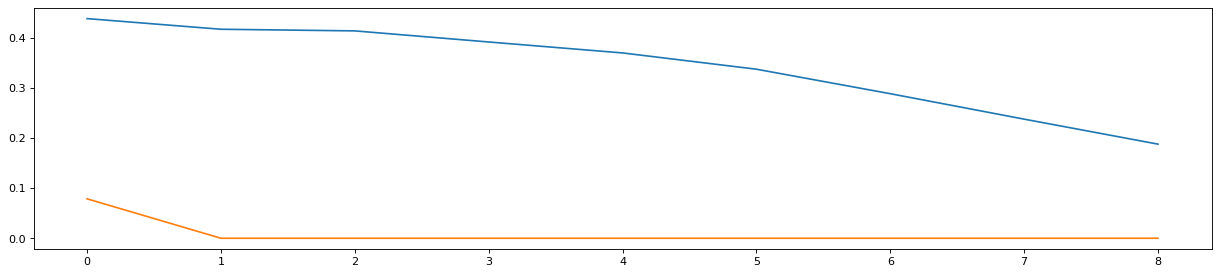

In [0]:
import scipy.integrate
from numpy import exp
from math import inf
pb_th= lambda u:exp(-0.5*u**2)
pbs_th=np.array([])
for ebn01 in ebn0:
    pbs_th = np.append(pbs_th, scipy.integrate.quad(pb_th, math.sqrt(2*10**(ebn01)), +inf)[0]/(math.sqrt(2*math.pi)))
print(pbs_th)
plt.figure(num=None, figsize=(19,4), dpi=80)
plt.plot(ebn0,pbs)
plt.plot(ebn0,pbs_th)
plt.show()

2.0
2.5178508235883346
3.169786384922227
3.990524629937759
5.02377286301916
6.324555320336759
7.9621434110699445
10.023744672545444
12.619146889603867
[4.55002639e-02 2.48300267e-02 1.18073317e-02 4.72695370e-03
 1.52551043e-03 3.75744381e-04 6.59273020e-05 7.55426438e-06
 5.06661545e-07]


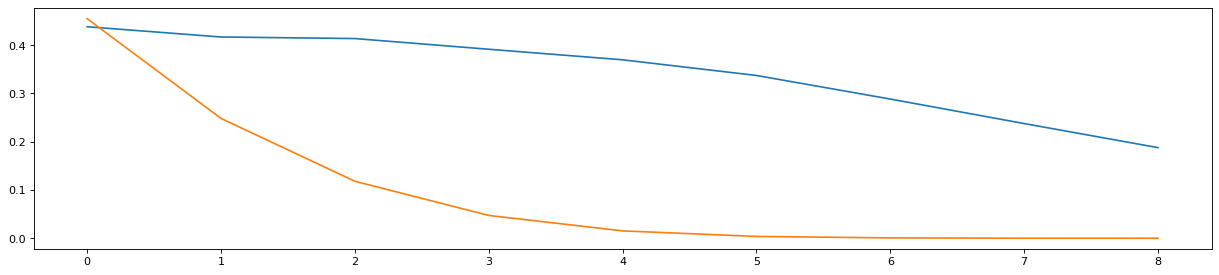

In [0]:
import scipy.integrate
from numpy import exp
from math import inf
pbs_th=np.array([])
for ebn01 in ebn0:
    pbs_th = np.append(pbs_th, math.erfc(math.sqrt(2*10**(ebn01/10))))
    print(2*10**(ebn01/10))
print(pbs_th)
plt.figure(num=None, figsize=(19,4), dpi=80)
plt.plot(ebn0,pbs)
plt.plot(ebn0,pbs_th)
plt.show()